In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

2023-05-10 12:55:58.923721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [59]:
"""
    Inputs:
     - SoverK, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Output:
    MC-simulated price of the option
"""
def hestonOptionPrice(S, K, v0, rho, kappa, theta, sigma, r, T, N, M):
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=1.0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    #computing asset prices and variances over time
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    #computing european call option price as the discounted expected value of the payoff
    res = np.exp(-r*T)*np.mean(np.maximum(S[-1] - K, 0))
    return res


In [73]:
size = 10000 #with a size of 10 000 takes about 2 hours
SoverKs = np.random.uniform(0.6, 1.4, size=size) #random prices
maturities = np.random.uniform(0.1, 1.4, size=size)
rhos = np.random.uniform(-0.95, 0.0, size=size)
kappas = np.random.uniform(0.0, 2.0, size=size)
avgvariances = np.random.uniform(0.0, 0.5, size = size)
volofvols = np.random.uniform(0.0, 0.5, size=size)
initialvars = np.random.uniform(0.05, 0.5, size=size)
rates = np.random.uniform(0.02, 0.1, size=size)
calls = np.array([hestonOptionPrice(SoverK, v0, rho, kappa, theta, sigma, r, T, 100, 100000) for (SoverK, v0, rho, kappa, theta, sigma, r, T) in 
                  zip(SoverKs, initialvars, rhos, kappas, avgvariances, volofvols, rates, maturities)])

In [77]:
data = pd.DataFrame()
data['SoverK'] = SoverKs
data['Maturity'] = maturities
data['RFR'] = rates
data['Correlation'] = rhos
data['Reversion Speed'] = kappas
data['Long Average Variance'] = avgvariances
data['Volatility of Volatility'] = volofvols
data['Initial Variance'] = initialvars
data['Call Price'] = calls

In [78]:
data.to_csv('heston_model.csv')

In [79]:
data

,SoverK,Maturity,RFR,Correlation,Reversion Speed,Long Average Variance,Volatility of Volatility,Initial Variance,Call Price
0,1.072113,1.082634,0.058396,-0.394098,1.062356,0.358241,0.171619,0.053580,0.246093
1,0.640792,0.215736,0.062335,-0.906624,0.535400,0.166322,0.485134,0.205258,0.000083
2,0.759151,0.779323,0.087909,-0.279591,0.923642,0.444810,0.189943,0.295859,0.136263
3,0.603717,1.014488,0.073001,-0.407065,0.779011,0.120044,0.354994,0.332474,0.064904
4,0.606568,1.052569,0.068895,-0.086174,1.292295,0.429553,0.032595,0.256452,0.105708
...,...,...,...,...,...,...,...,...,...
9995,0.616981,0.214711,0.093232,-0.535882,0.994572,0.015837,0.200912,0.409352,0.006432
9996,0.944580,0.624459,0.072776,-0.592923,0.133566,0.385083,0.252707,0.370641,0.190589
9997,0.791960,0.661505,0.025729,-0.944539,0.017640,0.274469,0.116897,0.487360,0.143469
9998,0.882573,1.067838,0.055072,-0.091029,1.669919,0.071510,0.029590,0.220176,0.135039


In [82]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.25)
xtrain = train[["SoverK", "Maturity", "RFR", "Correlation", "Reversion Speed", "Long Average Variance", "Volatility of Volatility", "Initial Variance"]]
ytrain = np.array(train["Call Price"]).reshape(len(train["Call Price"]),1)
xtest = test[["SoverK", "Maturity", "RFR", "Correlation", "Reversion Speed", "Long Average Variance", "Volatility of Volatility", "Initial Variance"]]
ytest = np.array(test["Call Price"]).reshape(len(test["Call Price"]),1)

In [85]:
model = keras.Sequential(
    [
    keras.layers.Dense(400, activation='relu', input_dim=xtrain.shape[1], kernel_initializer="glorot_uniform"),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(1)
    ]
)

2023-05-10 12:57:05.206302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [86]:
model.compile(loss='mse', optimizer='adam')

In [87]:
model.fit(xtrain, ytrain, epochs=250, batch_size=7500, validation_split=0.0, verbose=1)

Epoch 1/250
1/1 [==============================] - 0s 498ms/step - loss: 0.0503
Epoch 2/250
1/1 [==============================] - 0s 154ms/step - loss: 0.0318
Epoch 3/250
1/1 [==============================] - 0s 146ms/step - loss: 0.0152
Epoch 4/250
1/1 [==============================] - 0s 147ms/step - loss: 0.0086
Epoch 5/250
1/1 [==============================] - 0s 148ms/step - loss: 0.0117
Epoch 6/250
1/1 [==============================] - 0s 145ms/step - loss: 0.0112
Epoch 7/250
1/1 [==============================] - 0s 145ms/step - loss: 0.0080
Epoch 8/250
1/1 [==============================] - 0s 146ms/step - loss: 0.0065
Epoch 9/250
1/1 [==============================] - 0s 146ms/step - loss: 0.0080
Epoch 10/250
1/1 [==============================] - 0s 144ms/step - loss: 0.0081
Epoch 11/250
1/1 [==============================] - 0s 149ms/step - loss: 0.0061
Epoch 12/250
1/1 [==============================] - 0s 143ms/step - loss: 0.0053
Epoch 13/250
1/1 [===================

In [88]:
ypred = model.predict(xtest)

79/79 [==============================] - 0s 1ms/step


In [89]:
diff2 = ytest - ypred 
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.00881142])

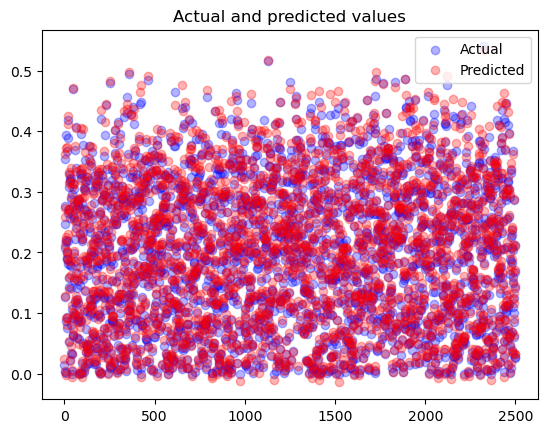

In [90]:
_, ax = plt.subplots()

ax.scatter(x = range(0, ytest.size), y=ytest, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, ypred.size), y=ypred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.legend()
plt.show()

Text(0.01, 0.5, 'RMSE:[0.00881142]')

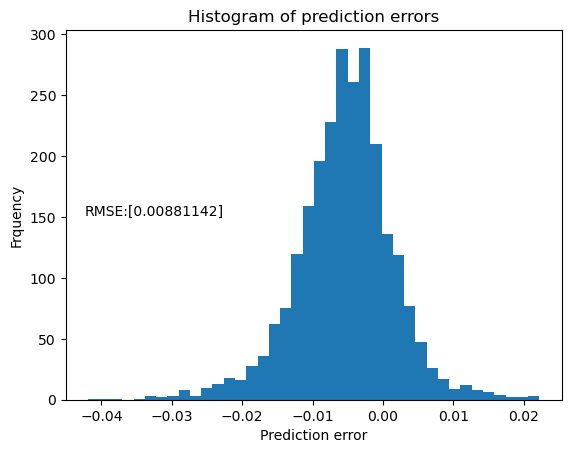

In [91]:
diff = ytest - ypred
plt.hist(diff, bins=40)
plt.title("Histogram of prediction errors")
plt.ylabel("Frquency")
plt.xlabel("Prediction error")
plt.text(0.01, 0.5, f"RMSE:{rmse}", transform=ax.transAxes)

In [92]:
xtest.shape

(2500, 8)

In [98]:
prices = np.linspace(0.6, 1.4, 100)
T = 0.5
RFR = 0.05
rho = -0.5
kappa = 1.0
avgvar = 0.25
volofvol = 0.25
v0 = 0.25

In [106]:
topred = np.array([[price, T, RFR, rho, kappa, avgvar, volofvol, v0] for price in prices])
actual = [hestonOptionPrice(price, v0, rho, kappa, avgvar, volofvol, RFR, T, 100, 100000) for price in prices]

In [103]:
predicted = model.predict(topred)

4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Predicted Call Prices Movements as Stock Prices goes Up (everything else fixed)')

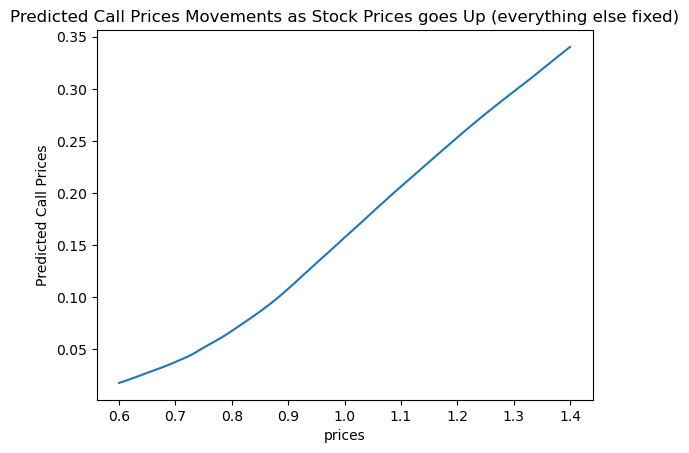

In [108]:
plt.plot(prices, predicted)
plt.xlabel("prices")
plt.ylabel("Predicted Call Prices")
plt.title("Predicted Call Prices Movements as Stock Prices goes Up (everything else fixed)")

Text(0.5, 1.0, 'MC Call Prices Movements as Stock Prices goes Up (everything else fixed)')

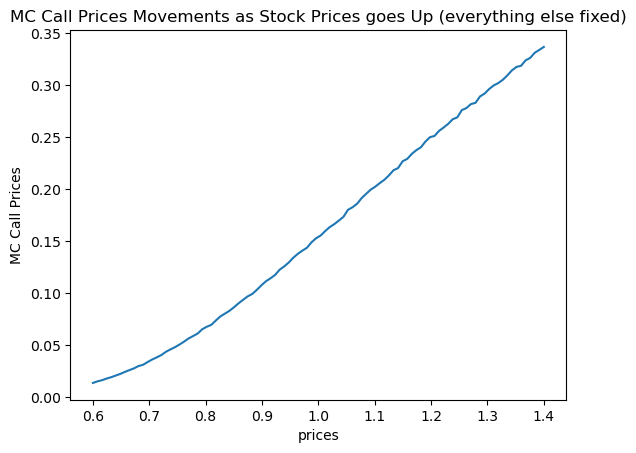

In [111]:
plt.plot(prices, actual)
plt.xlabel("prices")
plt.ylabel("MC Call Prices")
plt.title("MC Call Prices Movements as Stock Prices goes Up (everything else fixed)")

In [122]:
import xgboost as xgb

modelbis = xgb.XGBRegressor()
modelbis.fit(xtrain, ytrain)
predictedbis = modelbis.predict(xtest).reshape(2500, 1)

In [124]:
diff2 = ytest - predictedbis 
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.01037112])

In [165]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(2, weights="distance")


In [166]:
knn.fit(xtrain, ytrain.ravel())

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [167]:
predictedbis2 = knn.predict(xtest)

In [168]:
diff2 = ytest - predictedbis2.reshape(2500, 1)
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.0334114])

In [194]:
#HyperParameters Optimization
from sklearn import ensemble
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

rf = ensemble.RandomForestRegressor()
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['log2', 'sqrt', None],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [50, 100, 150, 200, 250],
               'criterion': ['squared_error', 'friedman_mse']}
rf_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring="neg_mean_squared_error")
rf_search.fit(xtrain, ytrain.ravel())
# rf.fit(xtrain, ytrain.ravel())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END bootstrap=True, criterion=friedman_mse, max_depth=40, max_features=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, criterion=squared_error, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END bootstrap=False, criterion=squared_error, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END bootstrap=False, criterion=squared_error, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END bootstrap=True, criterion=squared_error, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estim

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'friedman_mse'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200,
                                                         250]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [195]:
np.sqrt(-rf_search.score(xtest,ytest))

0.013746925742015439

In [171]:
predictedbis3 = rf.predict(xtest)

In [173]:
diff2 = ytest - predictedbis3.reshape(2500, 1)
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.01357753])

In [175]:
from sklearn import tree

tr = tree.DecisionTreeRegressor()
tr.fit(xtrain, ytrain.ravel())

DecisionTreeRegressor()

In [177]:
pred = tr.predict(xtest)

In [178]:
diff2 = ytest - pred.reshape(2500, 1)
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.02428734])